# Notebook for plotting

Before you can run this notebook you should run our model. You can find the run_model script in the `scripts/run_on_cluster` folder.



In [2]:
import pickle
import sys
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import datetime
import seaborn as sns

sys.path.append("../")
sys.path.append("../covid19_inference")

import covid19_soccer
from covid19_soccer.plot.utils import get_from_trace
import covid19_inference as cov19

Some general configs for matplotlib and file loading, you normally shouldn't need to change anything here except maybe the simulation parameters, if you changed them.

In [2]:
""" Matplotlib config
"""
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams["figure.figsize"] = [3.4, 2.7]  # APS single column
matplotlib.rcParams["figure.dpi"] = 300  # this primarily affects the size on screen
#matplotlib.rcParams['axes.linewidth'] = 0.3
matplotlib.rcParams["axes.labelcolor"] = "black"
matplotlib.rcParams["axes.edgecolor"] = "black"
matplotlib.rcParams["xtick.color"] = "black"
matplotlib.rcParams["ytick.color"] = "black"
matplotlib.rcParams["xtick.labelsize"] = 8
matplotlib.rcParams["ytick.labelsize"] = 8
matplotlib.rcParams["axes.labelsize"] = 8
matplotlib.rcParams["axes.titlesize"]= 10
matplotlib.rcParams["legend.fontsize"] = 6
matplotlib.rcParams["legend.title_fontsize"] = 8

""" Colors
Done with rcParams / see plot.rcParams
"""


""" General configs
"""
fig_path = "./figures"
countries = ["England","Scotland","Germany","France"]
xlim_ts = [datetime.datetime(2021,5,30),datetime.datetime(2021,7,23)] # Plotting range
tune = 200
draws = 300 
max_treedepth = 10
offset = 0 #offset of soccer games, mainly for sanity checks
width_prior_delay = 0.1

ylims_fraction = { #ylims for fraction plots
    "Germany":[0.8,1.7],
    "Scotland":[0.8,2.3],
    "England":[0.9,1.4],
    "France":[0.65,1.35],
}
ylims_cases = {
    "Germany":[0,200],
    "Scotland":[0,1100],
    "England":[0,1100],
    "France":[0,500],
}
# Save figure as pdf and png        
save_kwargs = {
    "transparent":True,
    "dpi":300,
    "bbox_inches":"tight"
}

Next we load all traces from the simulations. Check the path and simulation parameters if you can't load them here.

In [19]:
def load(fstr):
    with open(fstr, "rb") as f:
         return pickle.load(f)
        
models,traces,dls = {},{},{}
for country in countries:
    # Load trace, model and dataloader
    #'UEFA-beta=False-country=France-offset_games=0-draw_delay=True-weighted_alpha_prior=False-prior_delay=-1-tune=1000-draws=1500-max_treedepth=12.pickled'
    #'UEFA-beta=False-country=France-offset_games=0-draw_delay=True-weighted_alpha_prior=0-prior_delay=-1-width_delay_prior=0.1-sigma_incubation=-1.0-median_width_delay=1.5-tune=200-draws=300-max_treedepth=10.pickled'

    fstr=(f"/data.nst/jdehning/covid_uefa_traces2/UEFA"+
        f"-beta=False"+
        f"-country={country}"+
        f"-offset_games={offset}"+
        f"-draw_delay=True"+
        f"-weighted_alpha_prior=0"+
        f"-prior_delay={-1}"+
        f"-width_delay_prior={width_prior_delay}"+
        f"-sigma_incubation=-1.0"+
        f"-median_width_delay=1.5"+
        f"-tune={tune}"+
        f"-draws={draws}"+
        f"-max_treedepth={max_treedepth}.pickled")
    model, trace = load(fstr)
    dl = covid19_soccer.dataloader.Dataloader_gender(countries=[country])
    models[country]=model
    traces[country]=trace
    dls[country]=dl

## Single plots

Uncomment function calls below to generate them (output is writen to the `fig_path` folder

In [20]:
def get_from_trace(var,trace):
    """ Reshapes and returns an numpy array from an arviz trace
    """
    var = np.array(trace.posterior[var])
    var = var.reshape((var.shape[0]*var.shape[1],) + var.shape[2:])
    return var

def plot_casesOverview(trace,model,dl,country,ylim_fraction):
    """
    Plots an overview for the new cases i.e. cases per gender with model fit
    and the fraction between male and female.
    
    Parameters
    ----------
    trace:
        arviz trace of model run
    model:
        corresponding model
    dl:
        dataloader
    """
    
    new_cases = get_from_trace("new_cases",trace)
    fig, axes = plt.subplots(3,1,)

    ## New cases by sex
    for sex in range(2):
        cov19.plot._timeseries( # male
            x=pd.date_range(model.sim_begin,model.sim_end),
            y=new_cases[:,:,sex]/dl.population[sex,0]*1e6,
            ax=axes[sex],
            what="model",
            color=colors["male"] if sex==0 else colors["female"]
        )
        cov19.plot._timeseries( # female
            x=pd.date_range(model.data_begin,model.data_end),
            y=dl.new_cases_obs[:,sex,0]/dl.population[sex,0]*1e6,
            ax=axes[sex],
            what="data",
            color=colors["data"],
            ms=2
        )
        axes[sex].set_ylabel("Daily new cases\nrelative to population")
        #axes[sex].set_ylim(0,(dl.new_cases_obs[:,:,0]/dl.population[:,0]).max()*1e6+50)
        axes[sex].set(xticklabels=[])

    ## Fraction male/female
    cov19.plot._timeseries(
        x = pd.date_range(model.sim_begin,model.sim_end),
        y = (new_cases[:,:,0]/dl.population[0,0]) / (new_cases[:,:,1]/dl.population[1,0]), # male/female
        what="model",
        ax=axes[2],
        color="tab:gray"
    )
    cov19.plot._timeseries(
        x = pd.date_range(model.data_begin,model.data_end),
        y = (dl.new_cases_obs[:,0,0]/dl.population[0,0])/(dl.new_cases_obs[:,1,0]/dl.population[1,0]), # male/female
        what="data",
        ax=axes[2],
        color="tab:gray",
        ms=2
    )
    axes[2].set_ylabel("Fraction between\nmale and female cases")
    axes[2].set_ylim(ylim_fraction)
    # Apply same ylims to all axes
    for ax in axes:
        ax.set_xlim(xlim_ts)
        for label in ax.xaxis.get_ticklabels()[::2]:
            label.set_visible(False)
    axes[1].set(ylabel=None)
    
    # Set title for figure
    fig.suptitle(country)

    # Save figure as pdf and png
    kwargs = {
        "transparent":True,
        "dpi":300,
        "bbox_inches":"tight"
    }
    fig.savefig(f"{fig_path}/fig_casesOverview_{country}.pdf", **kwargs)
    fig.savefig(f"{fig_path}/fig_casesOverview_{country}.png", **kwargs)
    plt.close(fig=fig)
    
def plot_reproductionNumber(trace,model,dl,country):
    """
    Plots the base and soccer reproduction number 
    
    Parameters
    ----------
    trace:
        arviz trace of model run
    model:
        corresponding model
    dl:
        dataloader
    """
    R_base = get_from_trace("R_t_base",trace)
    R_soccer = get_from_trace("R_t_soccer",trace)
    C_base = get_from_trace("C_base",trace)
    C_soccer = get_from_trace("C_soccer",trace)
    
    # Calculate Effective R per sex
    #R_eff = np.einsum('dt,mf->dtmf',R_base, C_base) + np.einsum('dt,dmf->dtmf',R_soccer, C_soccer)
    
    fig,axes = plt.subplots(2,1)

    # Plot base and soccer Reproduction number
    cov19.plot._timeseries(
        x = pd.date_range(model.sim_begin,model.sim_end),
        y = R_base,
        what="model",
        ax=axes[0],
        color="tab:gray"
    )
    axes[0].axhline(1.0,color="tab:gray",ls="--",zorder=-5,lw=0.5)
    cov19.plot._timeseries(
        x = pd.date_range(model.sim_begin,model.sim_end),
        y = R_soccer,
        what="model",
        ax=axes[1],
        color="tab:gray"
    )
    axes[1].axhline(0,color="tab:gray",ls="--",zorder=-5,lw=0.5)
    
    
    axes[0].set_ylabel("Base\nreproduction number")
    axes[1].set_ylabel("Additive\nreproduction number")
    
    
    # Disable xticks of top axis 
    axes[0].set(xticklabels=[])
    
    # Apply same ylims to all axes
    for ax in axes:
        ax.set_xlim(xlim_ts)
        for label in ax.xaxis.get_ticklabels()[::2]:
            label.set_visible(False)
            
    # Set title for figure
    fig.suptitle(country)
    
    # Save figure as pdf and png        
    kwargs = {
        "transparent":True,
        "dpi":300,
        "bbox_inches":"tight"
    }
    fig.savefig(f"{fig_path}/fig_reproductionNumbers_{country}.pdf", **kwargs)
    fig.savefig(f"{fig_path}/fig_reproductionNumbers_{country}.png", **kwargs)
    plt.close(fig=fig)
    
def plot_alpha(trace,model,dl,country,beta=True):
    """
    Plots the base and soccer reproduction number 
    
    Parameters
    ----------
    trace:
        arviz trace of model run
    model:
        corresponding model
    dl:
        dataloader
    
    TODO
    ----
    maybe put into one figure
    """
    # Plot mean alpha
    ax = covid19_soccer.plot.distribution(
        model=model,
        trace=trace,
        key="alpha_mean",
        title="Mean effect of soccer games",
        dist_math="α_{mean}",
    )
    fig = ax[0].get_figure()
    # Save figure as pdf and png        
    kwargs = {
        "transparent":True,
        "dpi":300,
        "bbox_inches":"tight"
    }
    fig.savefig(f"{fig_path}/fig_alphaMean_{country}.pdf", **kwargs)
    fig.savefig(f"{fig_path}/fig_alphaMean_{country}.png", **kwargs)
    plt.close()

    # Plot delta alpha (per game)
    ax = covid19_soccer.plot.distribution(
        model=model,
        trace=trace,
        key="Delta_alpha_g_sparse",
        title="Effect for each soccer game $\Deltaα_g$",
        dist_math="\Deltaα")
    
    fig = ax[0].get_figure()
    # Save figure as pdf and png        
    kwargs = {
        "transparent":True,
        "dpi":300,
        "bbox_inches":"tight"
    }
    fig.savefig(f"{fig_path}/fig_alphaGames_{country}.pdf", **kwargs)
    fig.savefig(f"{fig_path}/fig_alphaGames_{country}.png", **kwargs)
    plt.close()
    
    
    ax = covid19_soccer.plot.distribution(
        model=model,
        trace=trace,
        key="sigma_alpha_g",
        title="Error of the effect (hierachical) $\sigma^α_g$",
        dist_math="\sigma^{α}"
    )
    fig = ax[0].get_figure()
    # Save figure as pdf and png        
    kwargs = {
        "transparent":True,
        "dpi":300,
        "bbox_inches":"tight"
    }
    fig.savefig(f"{fig_path}/fig_alphaError_{country}.pdf", **kwargs)
    fig.savefig(f"{fig_path}/fig_alphaError_{country}.png", **kwargs)
    plt.close()
    
def plot_violin(trace,model,dl,country,beta=False):
    """
    Violin plot for each game and country.
    
    If beta, uses beta variable instead of alpha
    """
    key = "alpha"
    if beta:
        key = "beta"
        
    # Sanitiy check, sometime countries do not have a stadium:
    if (len(dl.beta_prior[dl.beta_prior > 0]) == 0):
        return
    
    α_mean = get_from_trace(f"{key}_mean",trace)
    σ_g = get_from_trace(f"sigma_{key}_g",trace)
    Δα_g_sparse = get_from_trace(f"Delta_{key}_g_sparse",trace)
    alpha = α_mean[:,None] + np.einsum("dg,d->dg",Δα_g_sparse,σ_g)

    nGames = alpha.shape[-1]
    # Plot alpha
    fig, ax = plt.subplots(1,1,figsize=[3.4, 2.7*nGames/4])
    sns.violinplot(
        data=alpha,
        scale="width",
        inner="quartile",
        orient="h",
        ax=ax
    )
    
    # Get date of game and participants
    games = dl.timetable.loc[(dl.alpha_prior > 0)[0]]
    if beta:
        games = dl.timetable.loc[(dl.beta_prior > 0)[0]]
    
    # Construct ylabels
    ylabels= []
    for i, vals in games.iterrows():
        label =vals["date"].strftime("%d.%-m.%y")
        label +=f'\n{vals["team1"]} vs {vals["team2"]}'
        label +=f'\nin {vals["location"]}'
        ylabels.append(label)
        
    ax.set_yticklabels(ylabels)
    #ax.set_xlabel("Effect of game")

    # Set title for figure
    fig = ax.get_figure()
    fig.suptitle(country + f" - {key}")
    
    # Save figure as pdf and png        
    kwargs = {
        "transparent":True,
        "dpi":300,
        "bbox_inches":"tight"
    }
    fig.savefig(f"{fig_path}/fig_violin{key}_{country}.pdf", **kwargs)
    fig.savefig(f"{fig_path}/fig_violin{key}_{country}.png", **kwargs)
    plt.close(fig=fig)
    
def plot_contacts(trace,model,dl,country,):

    R_base = get_from_trace("R_t_base",trace)
    R_soccer = get_from_trace("R_t_soccer",trace)
    C_base = get_from_trace("C_base",trace)
    C_soccer = get_from_trace("C_soccer",trace)
    
    # Calculate Effective R per sex
    R_eff = np.einsum('dt,dmf->dtmf',R_base, C_base) + np.einsum('dt,dmf->dtmf',R_soccer, C_soccer)
  

    
    fig,axes = plt.subplots(C_base.shape[1],C_base.shape[2],)
    covid19_soccer.plot.distribution(
        model=model,
        trace=trace,
        key="C_base",
        dist_math="C_{base}",
        ax=axes
    )
    
    fig.suptitle(country + f" - C_base")
    
    # Save figure as pdf and png        
    kwargs = {
        "transparent":True,
        "dpi":300,
        "bbox_inches":"tight"
    }
    fig.savefig(f"{fig_path}/fig_C_base_{country}.pdf", **kwargs)
    fig.savefig(f"{fig_path}/fig_C_base_{country}.png", **kwargs)
    plt.close(fig=fig)
    
    fig,axes = plt.subplots(C_base.shape[1],C_base.shape[2],)
    covid19_soccer.plot.distribution(
        model=model,
        trace=trace,
        key="C_soccer",
        dist_math="C_{soccer}",
        ax=axes
    )
    
    # title
    fig.suptitle(country + f" - C_soccer")
    
    # Save figure as pdf and png        
    kwargs = {
        "transparent":True,
        "dpi":300,
        "bbox_inches":"tight"
    }
    fig.savefig(f"{fig_path}/fig_C_soccer_{country}.pdf", **kwargs)
    fig.savefig(f"{fig_path}/fig_C_soccer_{country}.png", **kwargs)
    plt.close(fig=fig)
    
    
    fig, axes = plt.subplots(1,2,figsize=(3.4,2.7/2))
    
    covid19_soccer.plot.distribution(
        model=model,
        trace=trace,
        key="factor_female",
        dist_math="f_{female}",
        ax=axes[0]
    )
    covid19_soccer.plot.distribution(
        model=model,
        trace=trace,
        key="c_off",
        dist_math="c_{offdiagonal}",
        ax=axes[1]
    )
    fig.savefig(f"{fig_path}/fig_overviewContact_{country}.pdf", **kwargs)
    fig.savefig(f"{fig_path}/fig_overviewContact_{country}.png", **kwargs)
    plt.close(fig=fig)


In [20]:
for country in countries:
    # Create first look plots for each country
    plot_casesOverview(trace,model,dl,country,ylim_fraction=ylims_fraction[country])
    plot_reproductionNumber(trace,model,dl,country)
    plot_alpha(trace,model,dl,country)
    plot_alpha(trace,model,dl,country)
    plot_violin(trace,model,dl,country)
    plot_violin(trace,model,dl,country,beta=True)
    plot_contacts(trace, model,dl,country)
    continue

## Main figure (overview)

Load the four main model runs, i.e. with default parameters:

In [ ]:
countries = ["England","Scotland","Germany","France"]
traces, models, dls = [], [], []
for country in countries:
    fstr=(f"/data.nst/jdehning/covid_uefa_traces5/UEFA"+
        f"-beta=False"+
        f"-country={country}"+
        f"-offset_games={offset}"+
        f"-draw_delay=True"+
        f"-weighted_alpha_prior=0"+
        f"-prior_delay={-1}"+
        f"-width_delay_prior={width_prior_delay}"+
        f"-sigma_incubation=-1.0"+
        f"-median_width_delay=1.5"+
        f"-tune={tune}"+
        f"-draws={draws}"+
        f"-max_treedepth={max_treedepth}.pickled")
    model, trace = load(fstr)
    dl = covid19_soccer.dataloader.Dataloader_gender(countries=[country])
    models.append(model)
    traces.append(trace)
    dls.append(dl)

Create multi overview plot for all four model runs:

In [ ]:
axes = covid19_soccer.plot.overview.multi(traces,models,dls)

# We can apply more markup to the axes here:
# axes[0][0].set_xlim()

# Show and save plot
fig = axes[0][0].get_figure()
plt.show()
fig.savefig(f"{fig_path}/overview.pdf", **save_kwargs)
fig.savefig(f"{fig_path}/overview.png", **save_kwargs)
plt.close(fig=fig)

To later insert to legend with affinity or illustrator, we need to create it separately 

NameError: name 'fig_path' is not defined

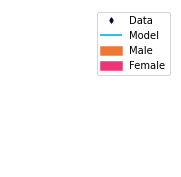

In [5]:
# Create legend
ax = covid19_soccer.plot.other.legend(prior=False,posterior=False)
fig = ax.get_figure()
fig.savefig(f"{fig_path}/legend.pdf", **save_kwargs)
fig.savefig(f"{fig_path}/legend.png", **save_kwargs)
plt.show()
plt.close(fig=fig)

# Other distributions

We want the following distributions:

- Delay mean
- Delay width
- female factor
- normal contactmatrix offdiag


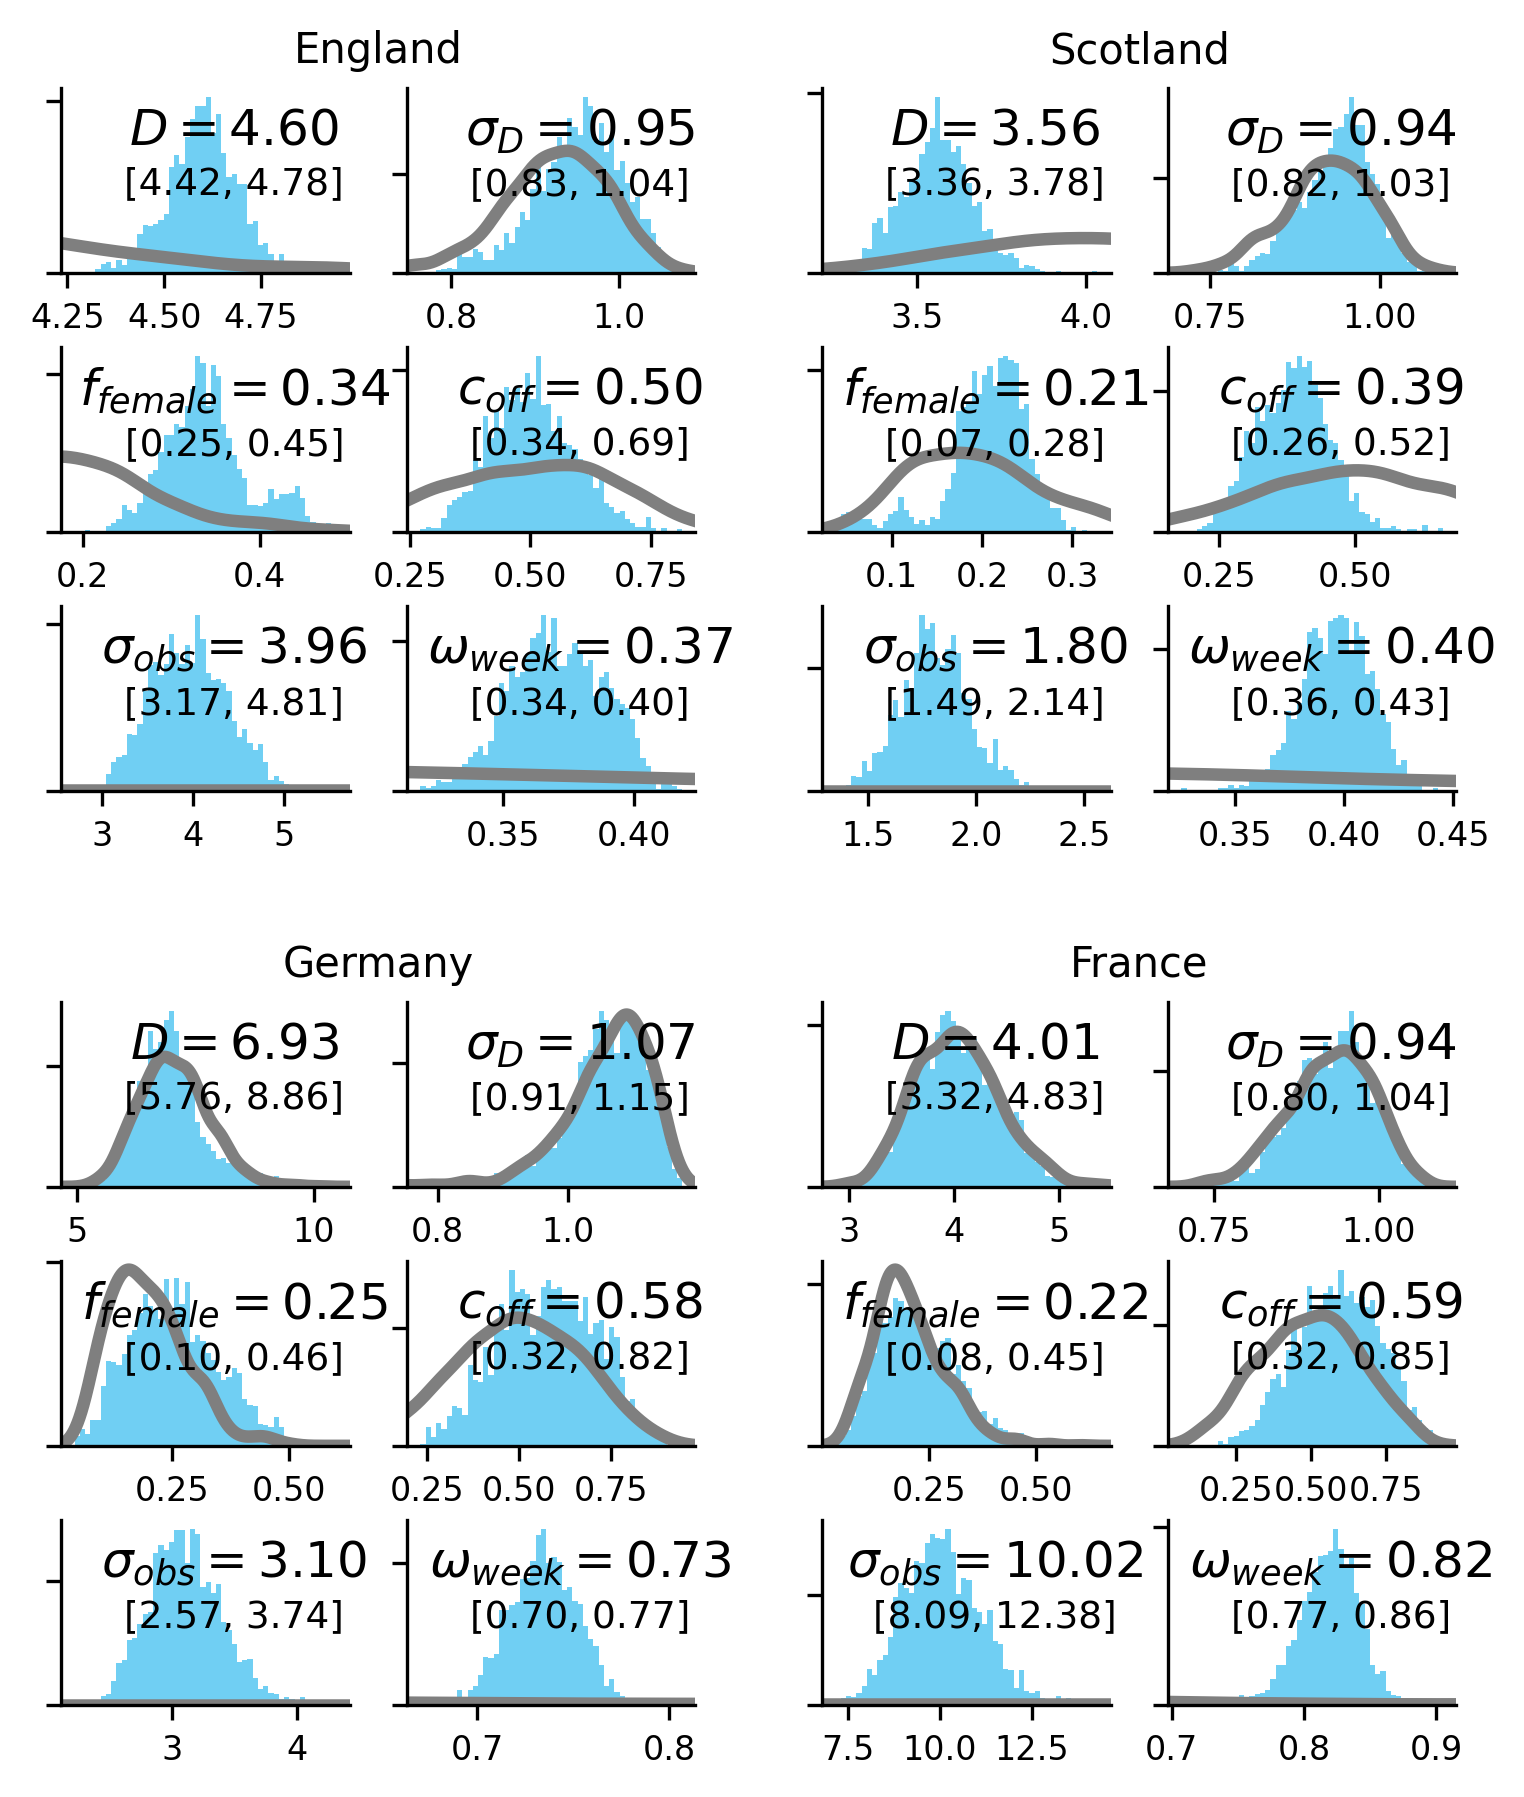

In [7]:
covid19_soccer.plot.rcParams["color_posterior"]=colors["fraction"]
covid19_soccer.plot.rcParams["color_prior"]="tab:gray"

fig =  plt.figure(figsize=(6,7))
# Two columns/rows
outer_grid = fig.add_gridspec(2, 2, wspace=0.2, hspace=0.3,)

axes = []
for a in range(2):
    for b in range(2):
        
        # gridspec inside gridspec
        inner_grid = outer_grid[a,b].subgridspec(3, 2, width_ratios=[1,1],hspace=0.4,)
        country = id2_country[a,b]
        trace = traces[country]
        model = models[country]
        
        ax = plt.Subplot(fig, outer_grid[a,b])
        ax.set_title(country)
        ax.axis('off')
        fig.add_subplot(ax)
        # Delay
        a1 = fig.add_subplot(inner_grid[0,0])
        covid19_soccer.plot.distribution(
            model,
            trace,
            "delay",
            nSamples_prior=1000,
            title="",
            dist_math="D",
            ax=a1,
        )
        
        # Delay width
        a2 = fig.add_subplot(inner_grid[0,1])
        covid19_soccer.plot.distribution(
            model,
            trace,
            "delay-width",
            nSamples_prior=1000,
            title="",
            dist_math="\sigma_D",
            ax=a2,
        )
        
        # female factor
        a3 = fig.add_subplot(inner_grid[1,0])
        covid19_soccer.plot.distribution(
            model,
            trace,
            "factor_female",
            nSamples_prior=1000,
            title="",
            dist_math="f_{female}",
            ax=a3,
        )
        
        # contact matrix offdiag
        a4 = fig.add_subplot(inner_grid[1,1])
        covid19_soccer.plot.distribution(
            model,
            trace,
            "c_off",
            nSamples_prior=1000,
            title="",
            dist_math="c_{off}",
            ax=a4,
        )

        # median_incubation
        #a5 = fig.add_subplot(inner_grid[2,0])
        #covid19_uefa.plot.distribution(
        #    model,
        #    trace,
        #    "median_incubation",
        #    nSamples_prior=1000,
        #    title="",
        #    dist_math="D_{lat}",
        #    ax=a5,
        #)
        # sigma
        a7 = fig.add_subplot(inner_grid[2,0])
        covid19_soccer.plot.distribution(
            model,
            trace,
            "sigma_obs",
            nSamples_prior=1000,
            title="",
            dist_math="\sigma_{obs}",
            ax=a7,
        )
        
        # I_begin
        a6 = fig.add_subplot(inner_grid[2,1])
        covid19_soccer.plot.distribution(
            model,
            trace,
            "weekend_factor",
            nSamples_prior=1000,
            title="",
            dist_math="\omega_{week}", #What was
            ax=a6,
        )


# Save figure as pdf and png        
kwargs = {
    "transparent":True,
    "dpi":300,
    "bbox_inches":"tight"
}
fig.savefig(f"{fig_path}/fig_distributions.pdf", **kwargs)
fig.savefig(f"{fig_path}/fig_distributions.png", **kwargs)

plt.show()
plt.close(fig=fig)

/tmp/ipykernel_789896/3768355805.py:3: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  Patch([0], [0], color=colors["fraction"],lw=2.5,),


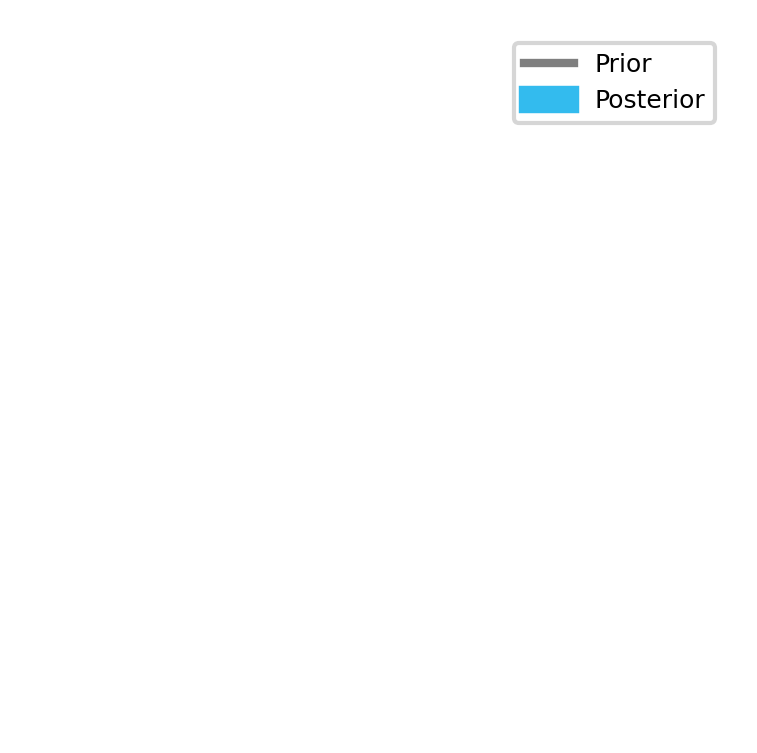

In [46]:
custom_lines = [
                Line2D([0], [0], color="tab:gray", lw=2),
                Patch([0], [0], color=colors["fraction"],lw=2.5,),
               
               ]
            
fig, ax = plt.subplots(figsize=(3,3))
ax.legend(custom_lines, ['Prior','Posterior',])
ax.axis('off')
fig.savefig(f"{fig_path}/legend_dist.pdf", **kwargs)
fig.savefig(f"{fig_path}/legend_dist.png", **kwargs)
plt.show()
plt.close(fig=fig)

## All reproduction numbers

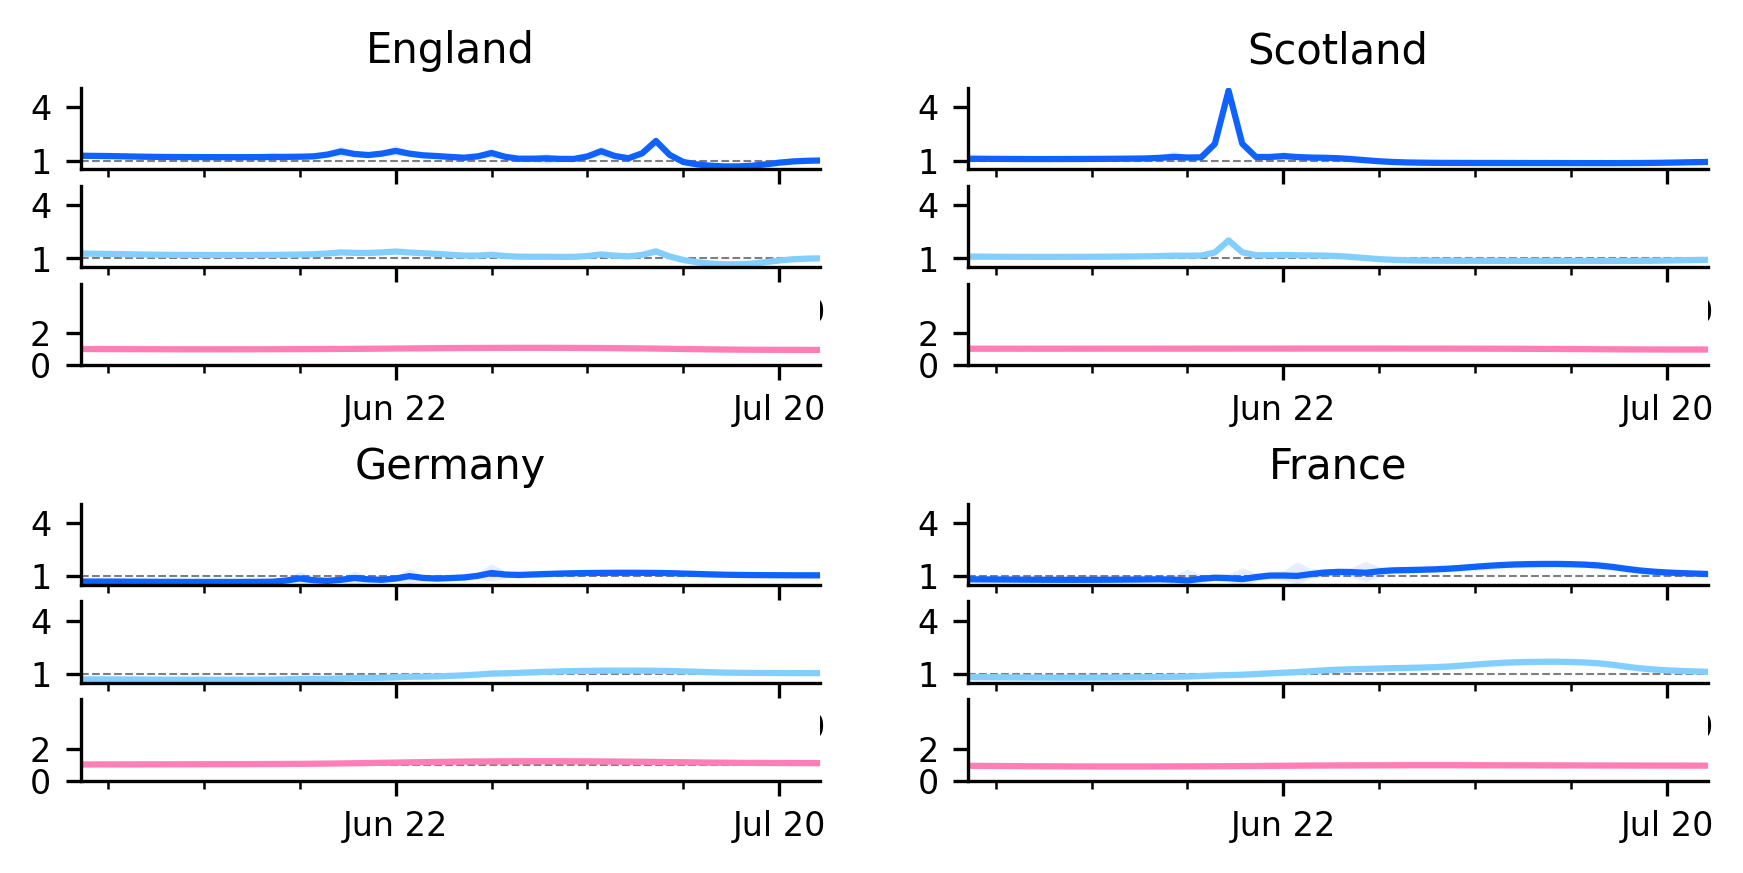

In [702]:
def plot_Rtotal(trace,model,ax,index=0,**kwargs):
    R_base = get_from_trace("R_t_base",trace)
    R_soccer = get_from_trace("R_t_soccer",trace)
    C_base = get_from_trace("C_base",trace)
    C_soccer = get_from_trace("C_soccer",trace)
    
    # Calculate Effective R per sex
    R_eff = np.einsum('dt,dmf->dtmf',R_base, C_base) + np.einsum('dt,dmf->dtmf',R_soccer, C_soccer)
    R_eff = R_eff.sum(axis=-1)


    cov19.plot._timeseries(
        x = pd.date_range(model.sim_begin,model.sim_end),
        y = R_eff[:,:,index],
        ax=ax,
        what="model",
        **kwargs
    )
    ax.axhline(1.0,color="tab:gray",ls="--",zorder=-5,lw=0.5)
    return ax


def plot_Rnoise(trace,model,ax,**kwargs):
    R_t_add_noise_fact = get_from_trace("R_t_add_noise_fact",trace)
    
    cov19.plot._timeseries(
        x = pd.date_range(model.sim_begin,model.sim_end),
        y = R_t_add_noise_fact[:,:,0],
        ax=ax,
        what="model",
        **kwargs
    )
    ax.axhline(1.0,color="tab:gray",ls="--",zorder=-5,lw=0.5)
    return ax
    
fig =  plt.figure(figsize=(7,3))
# Two columns/rows
outer_grid = fig.add_gridspec(2, 2, wspace=0.2, hspace=0.5,)

axes = []
for a in range(2):
    for b in range(2):
        
        # gridspec inside gridspec
        inner_grid = outer_grid[a,b].subgridspec(3, 1,hspace=0.2)
        country = id2_country[a,b]
        trace = traces[country]
        model = models[country]
        
        a1 = fig.add_subplot(inner_grid[0])
        plot_Rtotal(trace,model,a1,index=0,color=colors["male"])
        
        a2 = fig.add_subplot(inner_grid[1])
        plot_Rtotal(trace,model,a2,index=1,color=colors["female"],)

        a3 = fig.add_subplot(inner_grid[2])
        plot_Rnoise(trace,model,a3,color=colors["Repr"],)
        
        
        # Markup
        a1.set_title(country)
        for ax in [a1,a2,a3]:
            ax.set_xlim(xlim_ts)
            ax.set_ylim(0.5,5.1)
            ax.set_yticks([1,4])
            #Locator
            ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=4))
            ax.xaxis.set_minor_locator(mdates.WeekdayLocator(interval=1))
            # Hide the right and top spines
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)     
        a1.set(xticklabels=[])
        
        ax.set_yticks([0,2])
        
plt.show()       

## Sanity check for the delays

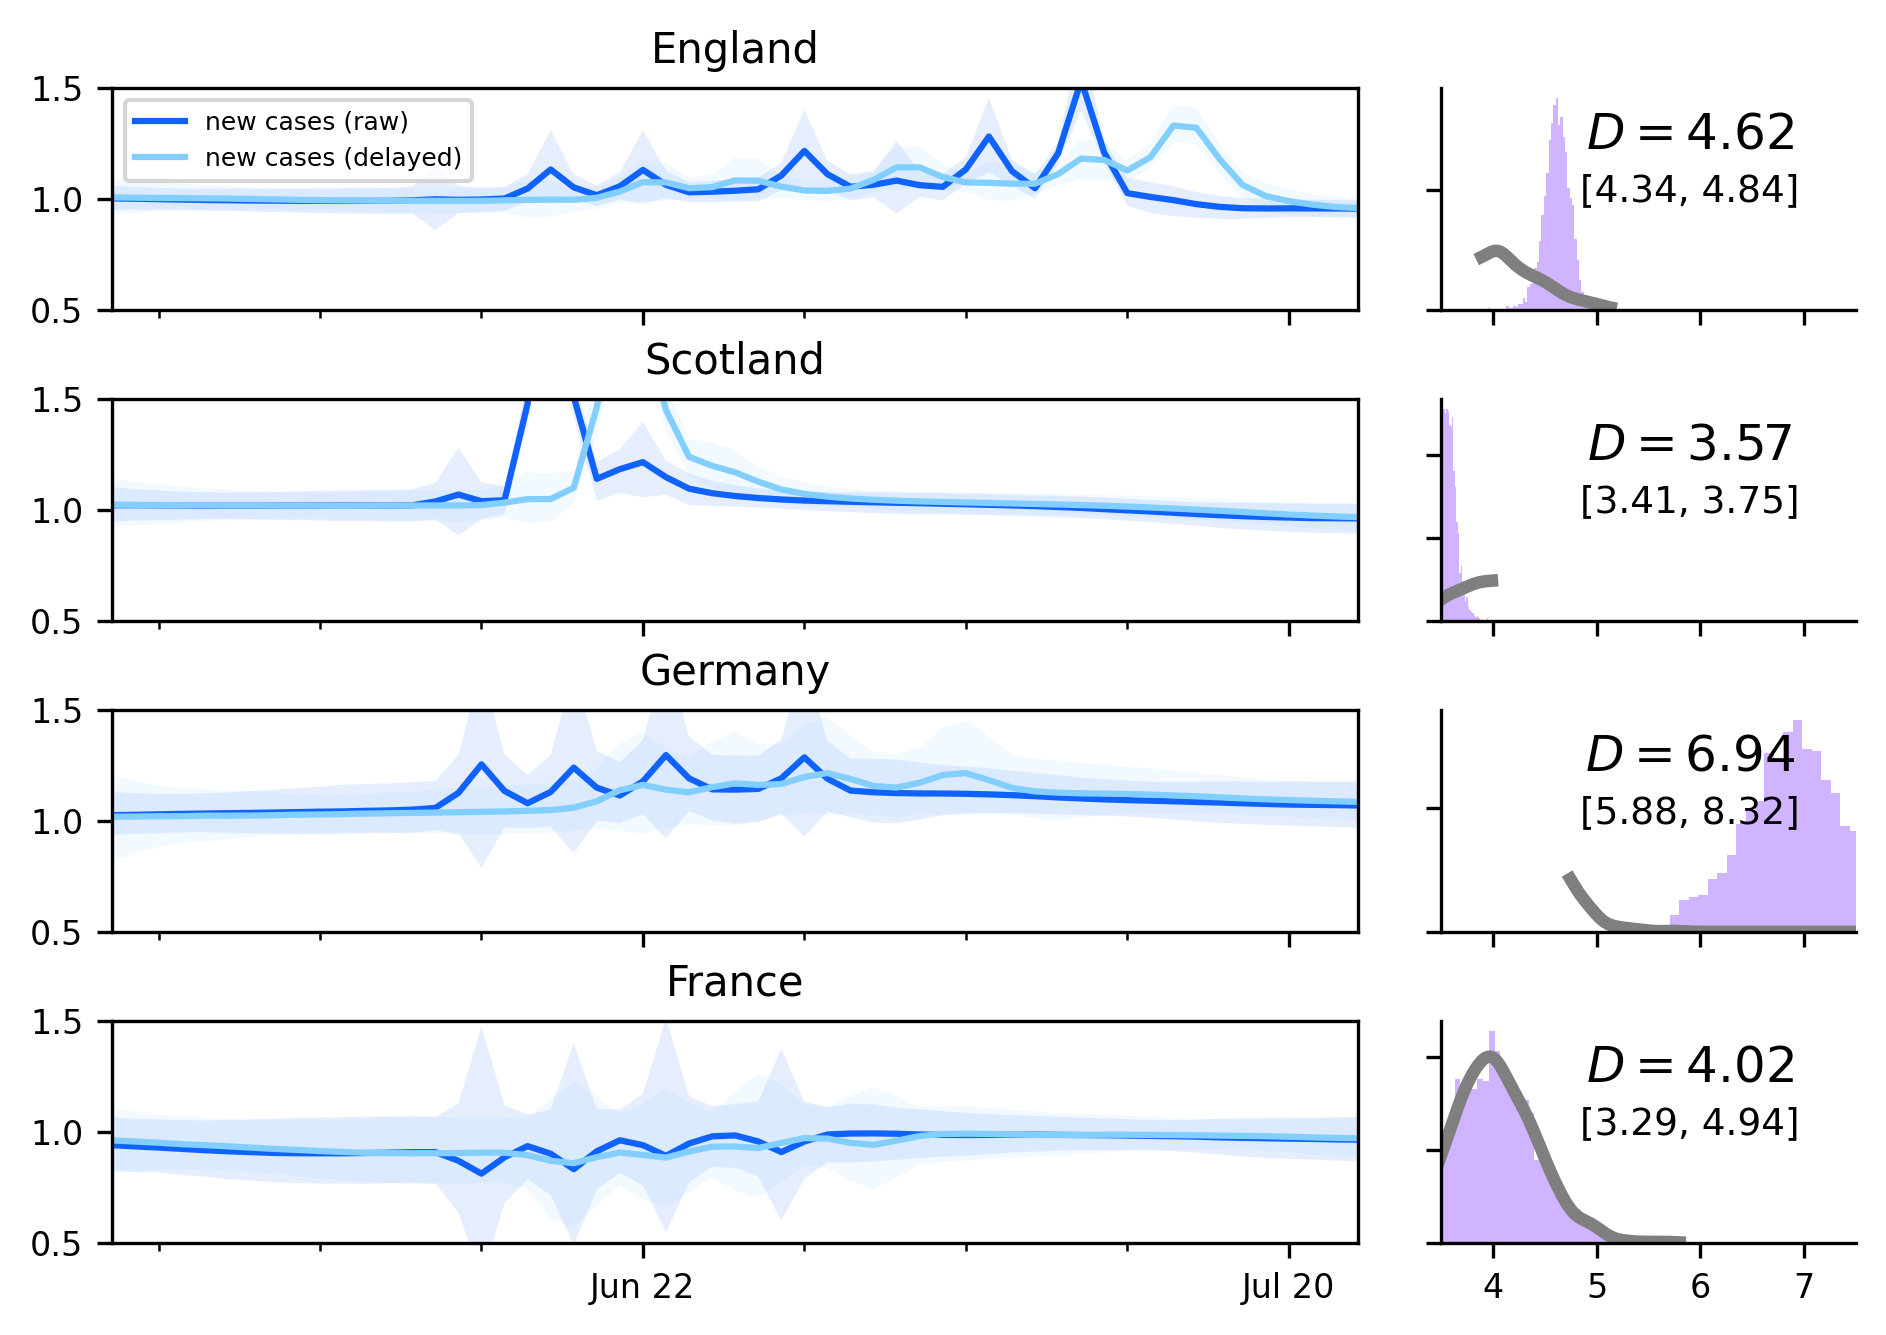

In [703]:
fig, axes = plt.subplots(4,2,figsize=(7.5,5),gridspec_kw={'width_ratios': [3, 1], "hspace":0.4,"wspace":0.1})
for i, country in enumerate(countries):
    trace = traces[country]

    new_E_t = get_from_trace("new_E_t",trace)
    new_cases = get_from_trace("new_cases",trace)

    cov19.plot._timeseries(
        x =  pd.date_range(model.sim_begin,model.sim_end),
        y = new_E_t[:,:,0]/new_E_t[:,:,1],
        what= "model",
        ax=axes[i,0],
        color=colors["male"],
        label="new cases (raw)"
    )
    cov19.plot._timeseries(
        x =  pd.date_range(model.sim_begin,model.sim_end),
        y = new_cases[:,:,0]/new_cases[:,:,1],
        what= "model",
        ax=axes[i,0],
        color=colors["female"],
        label="new cases (delayed)"
    )
    axes[i,0].set_xlim(xlim_ts)
    axes[i,0].xaxis.set_major_locator(mdates.WeekdayLocator(interval=4))
    axes[i,0].xaxis.set_minor_locator(mdates.WeekdayLocator(interval=1))
    axes[i,0].set_ylim(0.5,1.5)
    
    covid19_uefa.plot.distribution(
        model=model,
        trace=trace,
        key="delay",
        dist_math="D",
        ax= axes[i,1]
    )
    axes[i,1].set_xlim(3.5,7.5)
    
    if i < 3:
        axes[i,0].set(xticklabels=[])
        axes[i,1].set(xticklabels=[])
    axes[i,0].set_title(country)
axes[0,0].legend()
#fig.savefig(f"{fig_path}/delay_sanity.pdf", **kwargs)
#fig.savefig(f"{fig_path}/delay_sanity.png", **kwargs)
plt.show()
plt.close(fig=fig)

## Sanity check for the games at different time

In [18]:
offsets = [0,4]

models,traces,dls = {},{},{}
for country in countries:
    traces[country]={}
    dls[country]={}
    models[country]={}
    for offset in offsets:
        # Load trace, model and dataloader
        fstr=(f"../scripts/run_on_cluster/pickled/UEFA"+
        f"-beta=True"+
        f"-country={country}"+
        f"-offset_games={offset}"+
        f"-draw_delay=False"+
        f"-weighted_alpha_prior=True"+
        f"-tune={tune}"+
        f"-draws={draws}"+
        f"-max_treedepth={max_treedepth}.pickled")

        model, trace = load(fstr)
        dl = covid19_uefa.dataloader.Dataloader_gender(countries=[country],offset_games=offset)
        models[country][str(offset)]=model
        traces[country][str(offset)]=trace
        dls[country][str(offset)]=dl

FileNotFoundError: [Errno 2] No such file or directory: '../scripts/run_on_cluster/pickled/UEFA-beta=True-country=England-offset_games=0-draw_delay=False-weighted_alpha_prior=True-tune=1000-draws=1500-max_treedepth=12.pickled'

In [ ]:
fig, axes = plt.subplots(4,3, figsize=(7.5,5),gridspec_kw={'width_ratios': [3, .5, .5], "hspace":0.4,"wspace":0.1} )

for c, country in enumerate(countries):
    for o, offset in enumerate(offsets):
        trace = traces[country][str(offset)]
        model = models[country][str(offset)]
        R_soccer = get_from_trace("R_t_soccer",trace)
        
        # Plot additive R
        cov19.plot._timeseries(
            x = pd.date_range(model.sim_begin,model.sim_end),
            y = R_soccer,
            what="model",
            ax=axes[c,0],
            color=colors["male"],
            label=f"game offset {offset} days"
        )
        
        # Plot alpha mean
        plot_alphaMean(axes[c,1+o], trace, model, dls[country][str(offset)])
        axes[c,1+o].set_ylim(-2,5)
        if o == 0:
            axes[c,1+o].set(yticklabels=[])
            axes[c,1+o].set_ylabel("")
    if c < 3:
        axes[c,0].set(xticklabels=[])
        axes[c,1].set(xticklabels=[])
        axes[c,2].set(xticklabels=[])
    axes[c,0].set_title(country)
    
axes[0,0].legend()
plt.show()
plt.close(fig=fig)


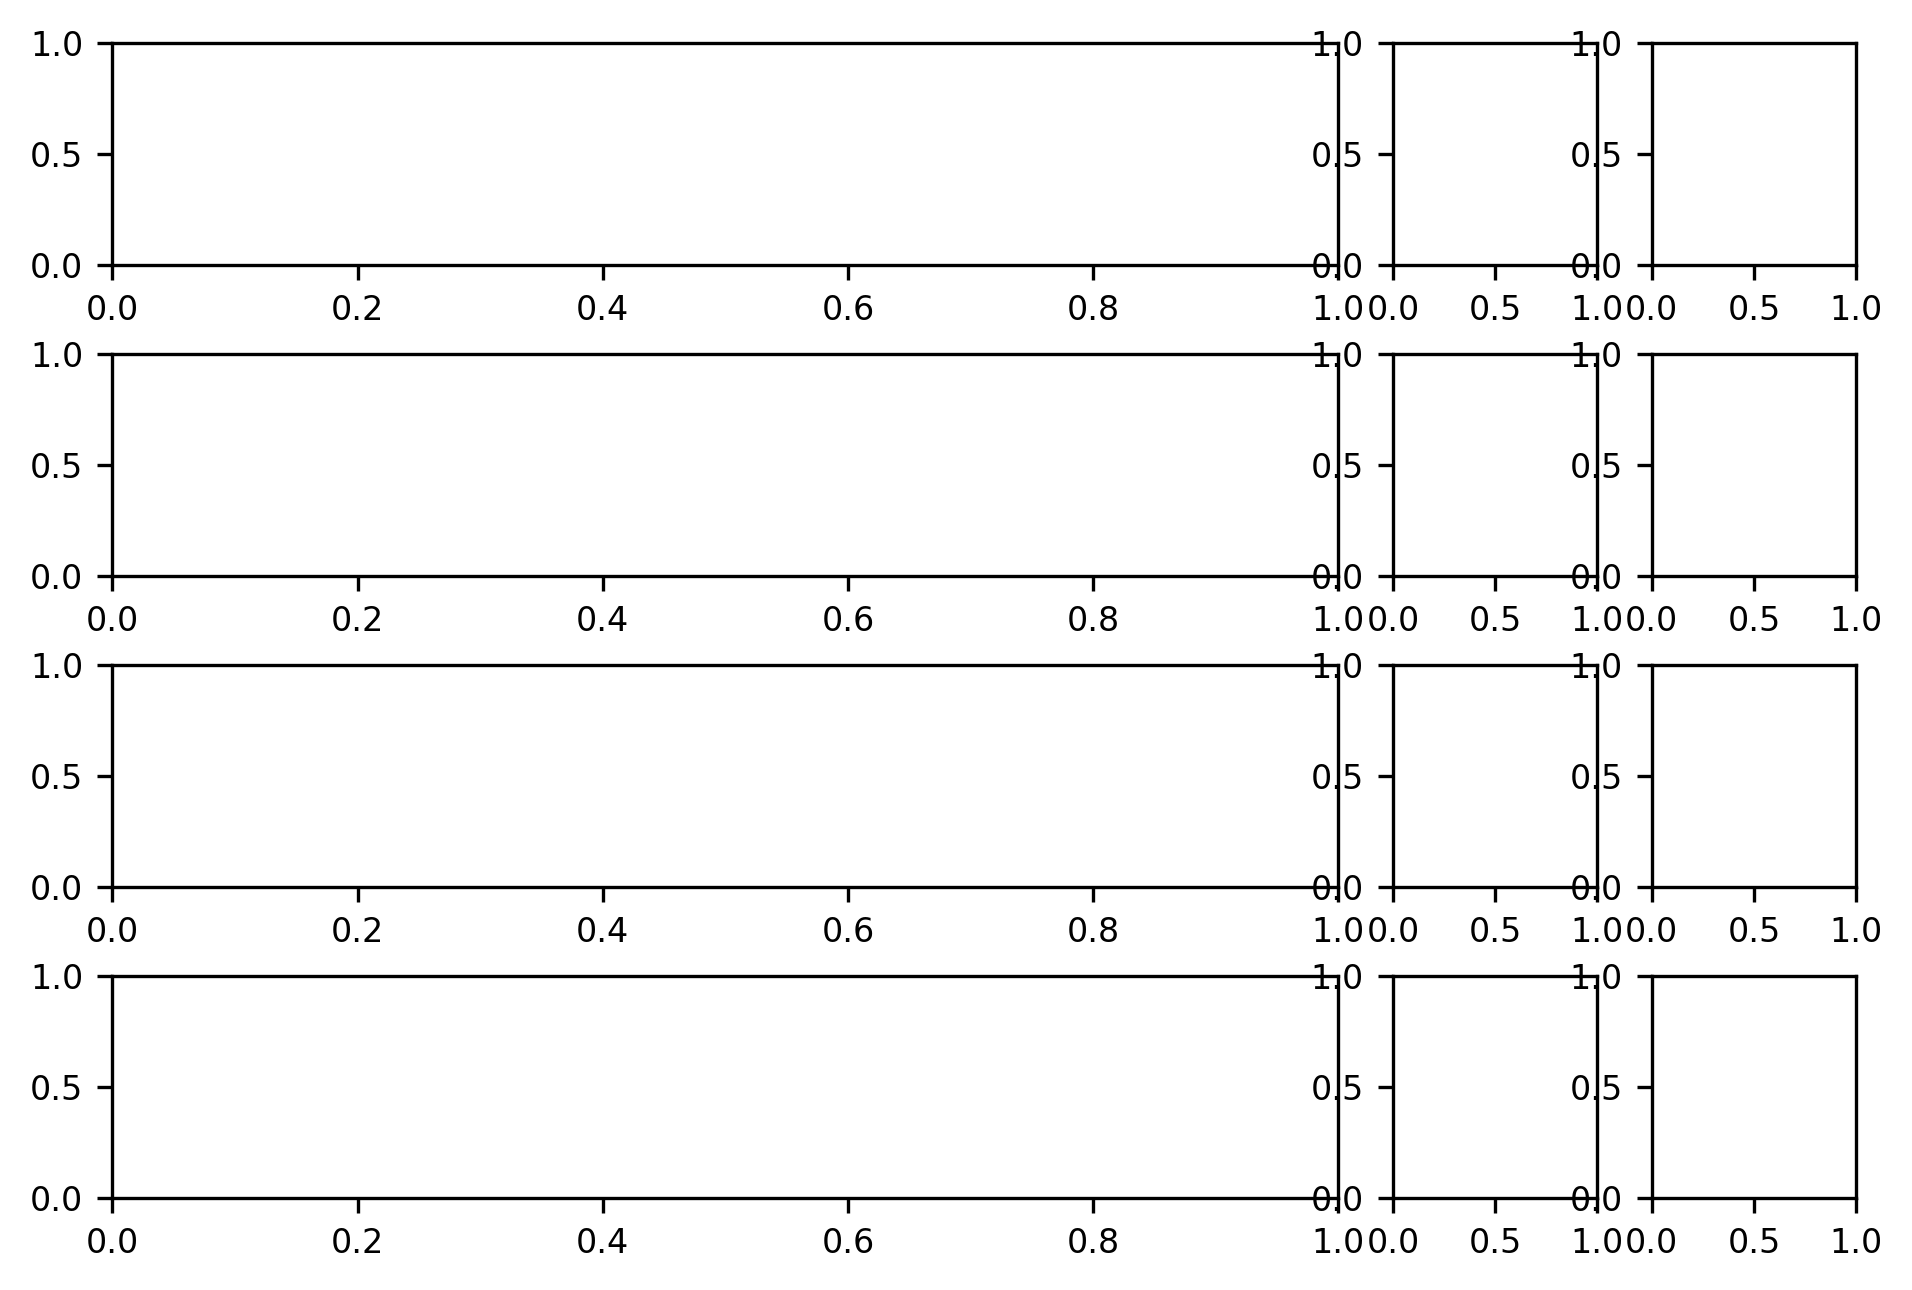

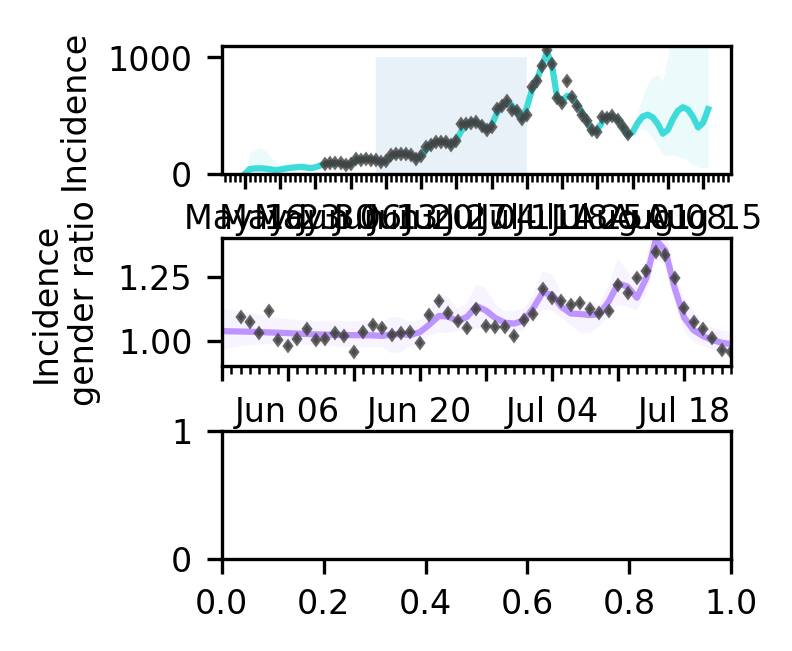

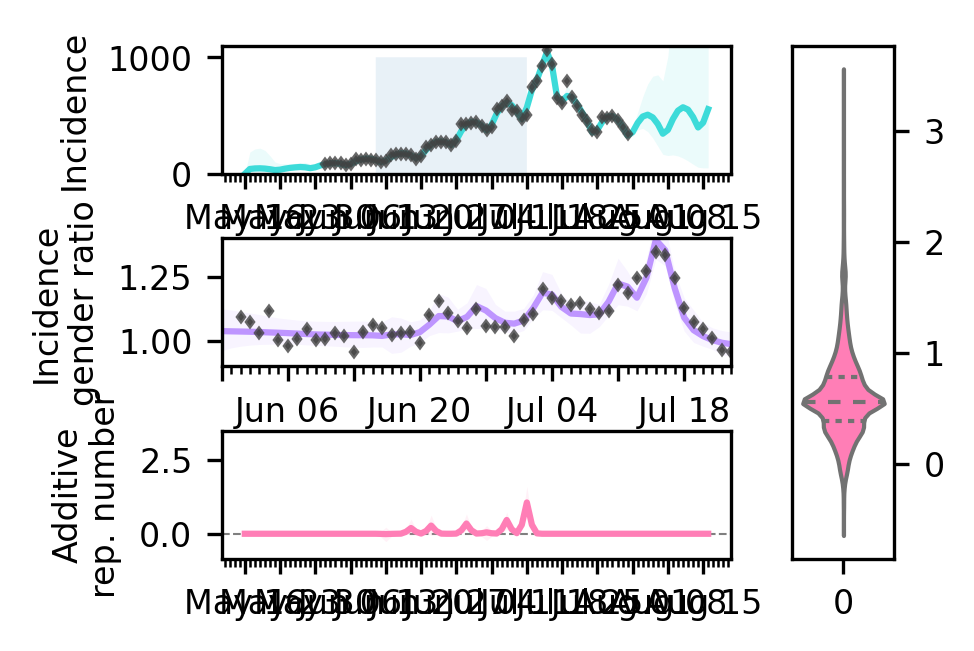

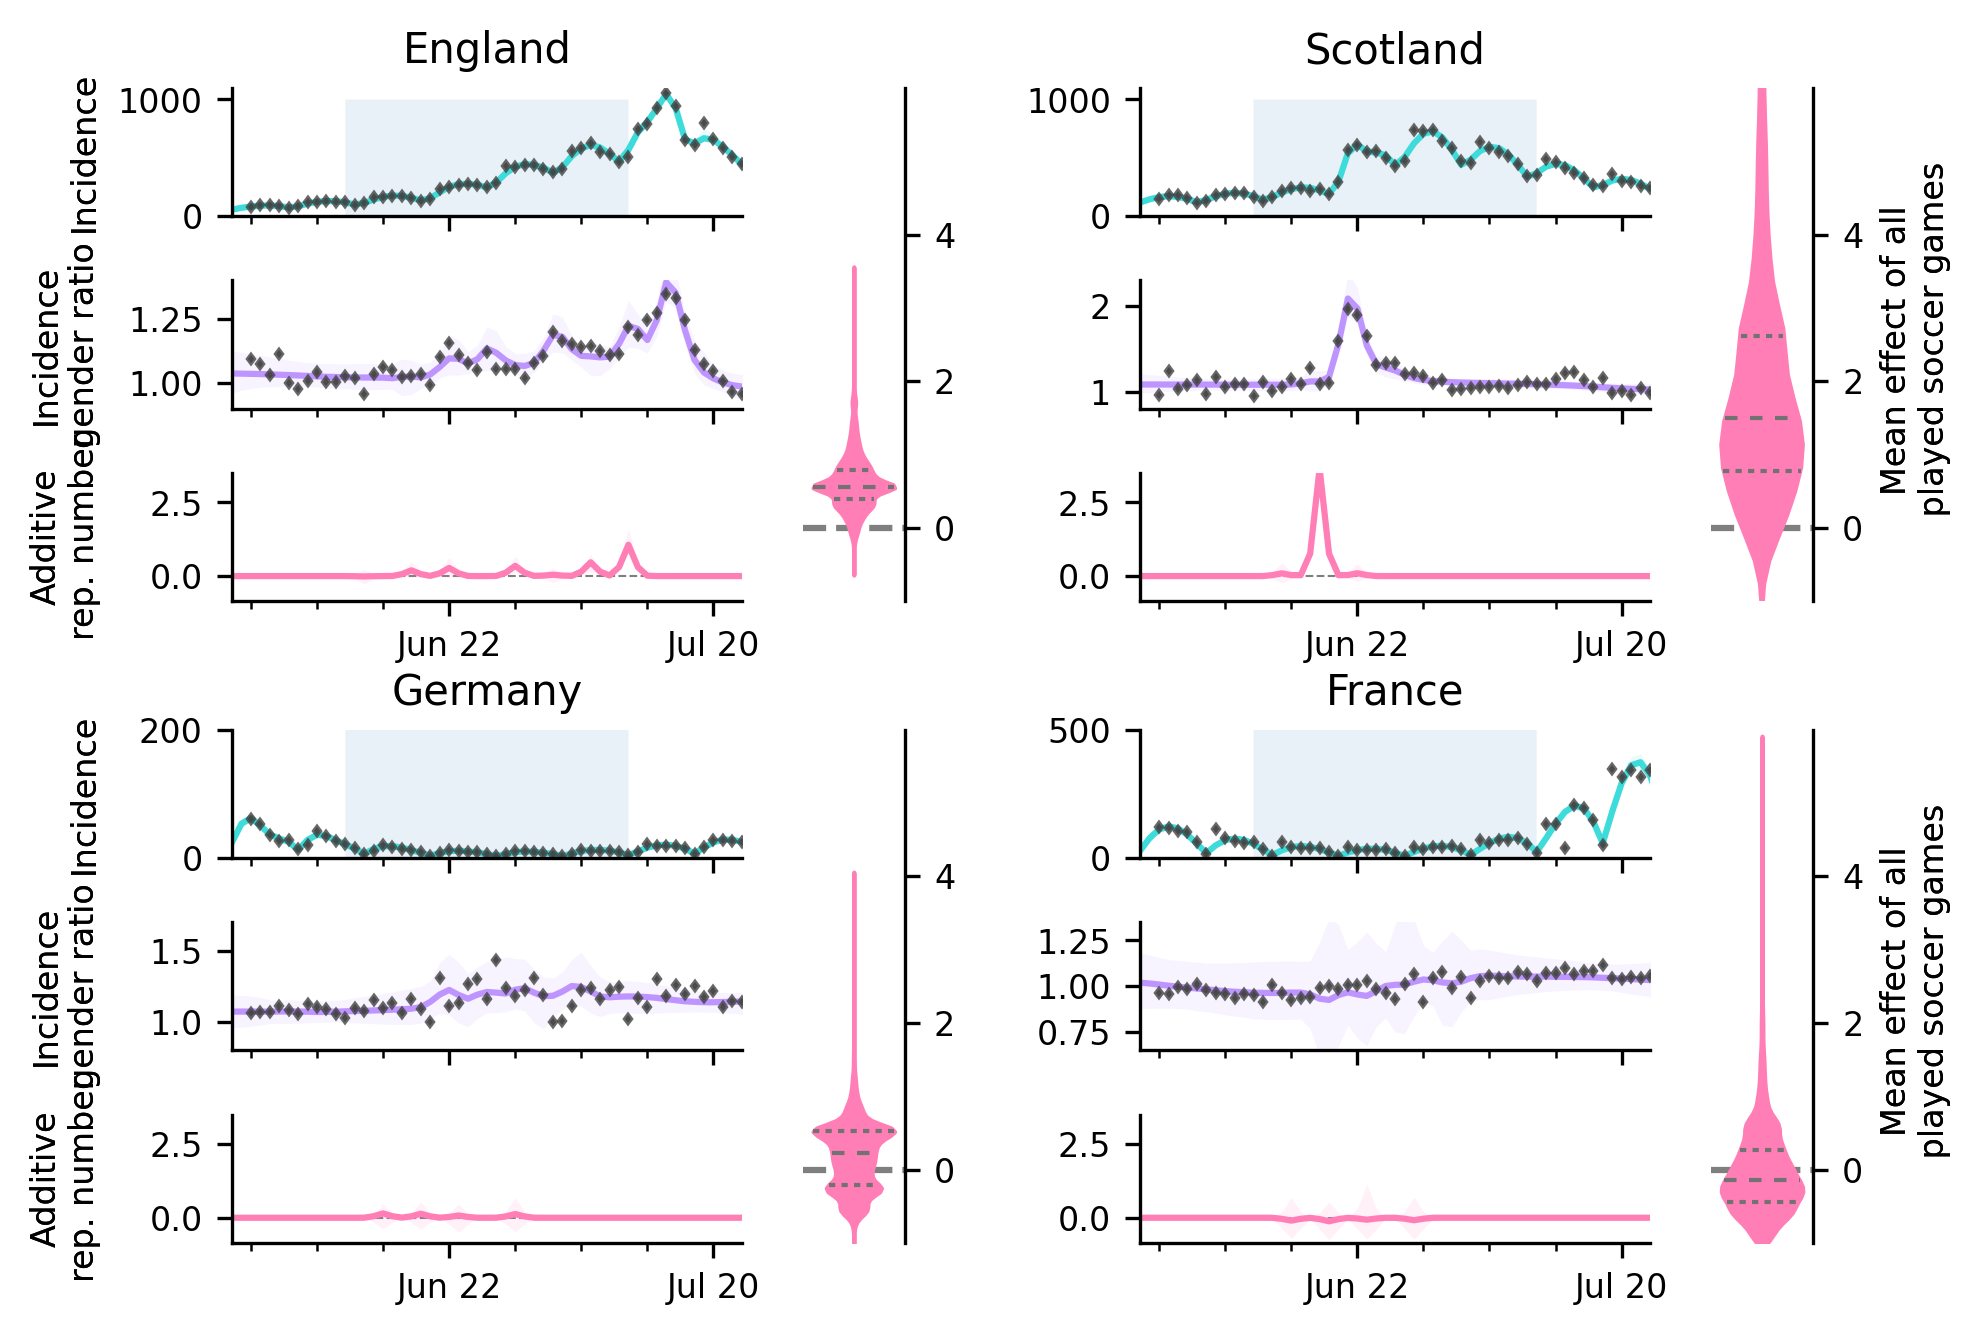

In [678]:

id2_country = np.array([["England","Scotland"],["Germany","France"]])


fig = plt.figure(figsize=(6.8,5))
# Two columns/rows
outer_grid = fig.add_gridspec(2, 2, wspace=0.35, hspace=0.25,)
# Two rows
plot_beta=False
axes = []
for a in range(2):
    for b in range(2):
        
        # gridspec inside gridspec
        if plot_beta:
            inner_grid = outer_grid[a,b].subgridspec(3, 3 , width_ratios=[1,0.3,0.3],wspace=0.5)
        else:
            inner_grid = outer_grid[a,b].subgridspec(3, 2, width_ratios=[1,0.2],hspace=0.5)
        
        # Create three subplots
        # - a1: fraction
        # - a2: R_soccer
        # - a3: alpha mean
        # - a4: beta mean
        country = id2_country[a,b]
        
        a1 = fig.add_subplot(inner_grid[0,0])
        plot_cases(a1, traces[country], models[country], dls[country],ylims_cases[country])
        
        a2 = fig.add_subplot(inner_grid[1,0])
        plot_fraction(a2, traces[country], models[country], dls[country], ylims_fraction[country])
        
        a3 = fig.add_subplot(inner_grid[2,0])
        plot_rsoccer(a3, traces[country], models[country], dls[country])
        
        
        index_alpha = -2 if plot_beta else -1
        a4 = fig.add_subplot(inner_grid[0:,index_alpha])
        plot_alphaMean(a4, traces[country], models[country], dls[country])

        if plot_beta and id2_country[a,b]!="France":
            a5 = fig.add_subplot(inner_grid[0:,-1])
            plot_alphaMean(a5, traces[country], models[country], dls[country],beta=True)

        # Markup
        a1.set_title(country)
        for ax in [a1,a2,a3]:
            ax.set_xlim(xlim_ts)
            #Locator
            ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=4))
            ax.xaxis.set_minor_locator(mdates.WeekdayLocator(interval=1))
            # Hide the right and top spines
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
                
        a1.set(xticklabels=[])
        a2.set(xticklabels=[])

        #a3.spines['right'].set_visible(False)
        a4.spines['top'].set_visible(False)
        a4.spines['bottom'].set_visible(False)
        a4.spines['left'].set_visible(False)
        a4.tick_params(bottom=False)
        if a == 1 and b == 1:
            a4.set_ylim(-1,6)
            a4.set(yticks=[0,2,4])
        else: 
            a4.set_ylim(-1,6)
            a4.set(yticks=[0,2,4])
            
        if plot_beta:
            a5.spines['top'].set_visible(False)
            a5.spines['bottom'].set_visible(False)
            a5.spines['left'].set_visible(False)
            a5.tick_params(bottom=False)       
            a5.set_xlabel("Stadium")
            a4.set_xlabel("Public\nviewing")
            a4.set_ylabel("")
            
            if a == 1 and b == 1:
                a5.set_ylim(-1,6)
                a5.set(yticks=[0,2,4])
            else: 
                a5.set_ylim(-1,6)
                a5.set(yticks=[0,2,4])
            
        

fig.align_ylabels()
# Save figure as pdf and png        
kwargs = {
    "transparent":True,
    "dpi":300,
    "bbox_inches":"tight"
}
fig.savefig(f"{fig_path}/fig_1_alt.pdf", **kwargs)
fig.savefig(f"{fig_path}/fig_1_alt.png", **kwargs)
plt.show()
plt.close(fig=fig)

# Compute loo score

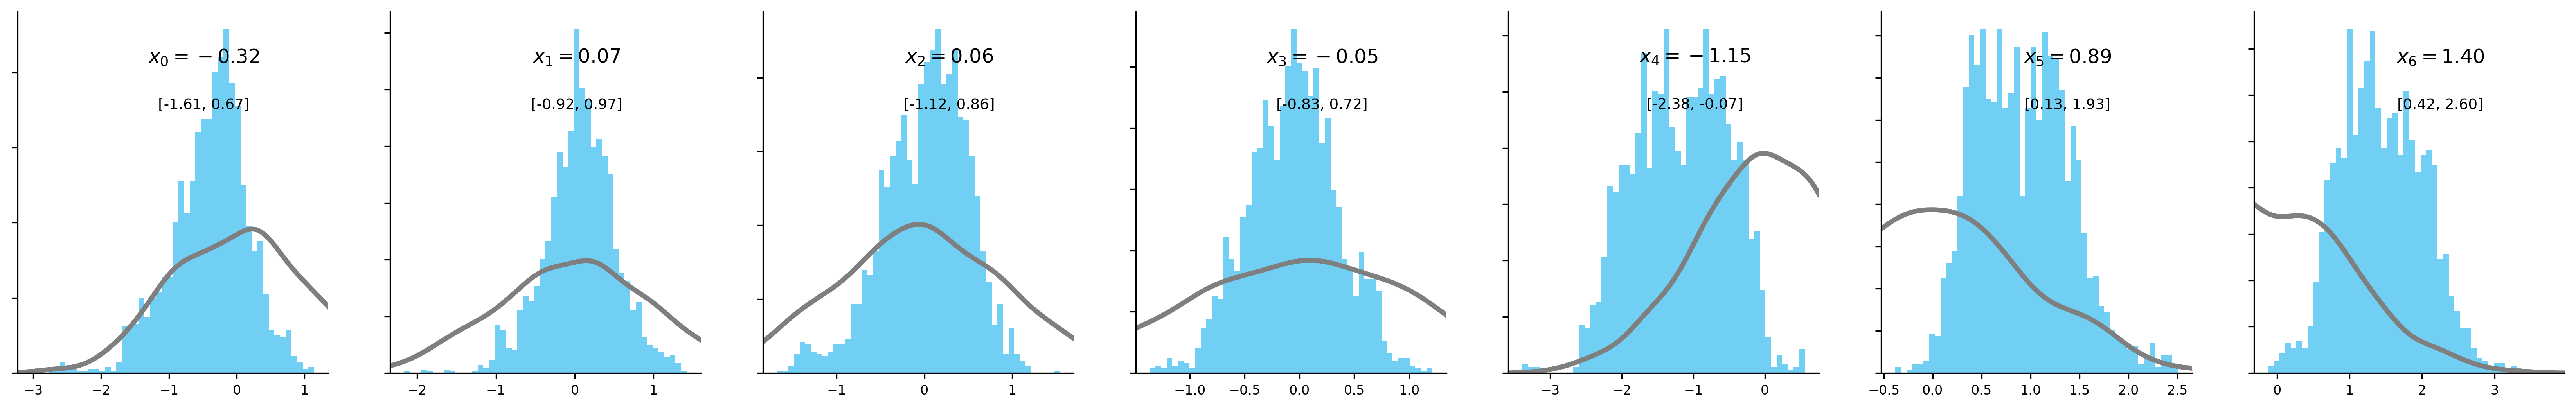

In [18]:
covid19_soccer.plot.distribution(
    models["England"],
    traces["England"],
    "Delta_alpha_g_sparse"
)
plt.show()

In [82]:
import arviz as az
loo_scores = {}
for offset in [0,1,28]:
    for delay in [3,5,8]:
        # Load trace, model and dataloader
        #'UEFA-beta=False-country=France-offset_games=0-draw_delay=True-weighted_alpha_prior=False-prior_delay=-1-tune=1000-draws=1500-max_treedepth=12.pickled'

        fstr=(f"/data.nst/jdehning/covid_uefa_traces/UEFA"+
            f"-beta=False"+
            f"-country={'Scotland'}"+
            f"-offset_games={offset}"+
            f"-draw_delay=True"+
            f"-weighted_alpha_prior=False"+
            f"-prior_delay={delay}"+
            f"-tune={tune}"+
            f"-draws={draws}"+
            f"-max_treedepth={max_treedepth}.pickled")
        model, trace = load(fstr)
        loo_scores[fstr] = az.loo(trace)

KeyboardInterrupt: 

In [48]:
print(loo_scores)

{'/data.nst/jdehning/covid_uefa_traces/UEFA-beta=False-country=Scotland-offset_games=0-draw_delay=True-weighted_alpha_prior=False-prior_delay=3-tune=1000-draws=1500-max_treedepth=12.pickled': Computed from 12000 by 122 log-likelihood matrix

         Estimate       SE
elpd_loo  -694.66    10.90
p_loo       23.64        -, '/data.nst/jdehning/covid_uefa_traces/UEFA-beta=False-country=Scotland-offset_games=0-draw_delay=True-weighted_alpha_prior=False-prior_delay=5-tune=1000-draws=1500-max_treedepth=12.pickled': Computed from 12000 by 122 log-likelihood matrix

         Estimate       SE
elpd_loo  -696.73    11.14
p_loo       24.90        -, '/data.nst/jdehning/covid_uefa_traces/UEFA-beta=False-country=Scotland-offset_games=0-draw_delay=True-weighted_alpha_prior=False-prior_delay=8-tune=1000-draws=1500-max_treedepth=12.pickled': Computed from 12000 by 122 log-likelihood matrix

         Estimate       SE
elpd_loo  -699.16    11.33
p_loo       26.18        -

There has been a warning durin